In [1]:
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:
#   Robin Krüger (Lund University),
#   Anne Marie Faaborg (Aarhus University), 
#   Adam Cretton (Technical University of Denmark),
#   Rasmus J. Pedersen (Technical University of Denmark)

Showcase wood dataset:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.13480488.svg)](https://doi.org/10.5281/zenodo.13480488)

# Exciscope Polaris phase contrast reconstruction with CIL

In this notebook, tomographic projections from the Exciscope Polaris instrument are reconstructured using the Core Imaging Library (CIL). The reconstruction includes phase retrieval and ring artefact correction.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import qim3d #https://platform.qim.dk/qim3d/
import matplotlib.pyplot as plt
import json
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector, PaganinProcessor, RingRemover
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer

## Data Structure

The data from the Exciscope Polaris is available in two folders: 01-ff containing flat field images and 02-tomo containing the tomographic projections. The image files are in .tiff-format. The flat-field and projection images align around the image centers. Meta-data is in .json-format. The data structure is visualized below:

    ├── 01-ff/
    │   ├── Input/
    │   │   └── command.json 
    │   └── Output/
    │       └── Binaries/
    │           ├── f0000.tiff
    │           ├── f0001.tiff
    │           └── ...
    ├── 02-tomo/
    │   ├── Input/
    │   │   └── command.json   
    │   ├── Output/
    │   │   └── Binaries/
    │   │       ├── tomo0000.tiff
    │   │       ├── tomo0001.tiff
    │   │       └── ...
    │   └── scan_information.json
    └── scan_list.scanlist

## Import Metadata

The metadata needed for the reconstruction is extracted from the instrument files. **Note!** The pixel size is not available in the metadata and has been indicated manually for the used camera.

In [3]:
# choose scan path
scan_path = "./ses-240826-143058-woodzoom"
output_dir = "output/"
recon_name = "wood_test"

with open(scan_path+'/02-tomo/scan_information.json', 'r') as f:
  scan_information = json.load(f)
with open(scan_path+'/02-tomo/Input/command.json', 'r') as f:
  tomo_command = json.load(f)
with open(scan_path+'/01-ff/Input/command.json', 'r') as f:
  flat_command = json.load(f)

# Parsing of parameters from file
voxel_size_mm = scan_information['pixel_size_um']/1000
propagation_distance_mm = scan_information['propagation_distance_mm']
source_detector_mm = tomo_command['stage_position_mm']['camera_beam']
source_object_mm = tomo_command['stage_position_mm']['object_beam'] 
roi = tomo_command['camera']['roi_px']
num_pixels = [roi['right']-roi['left']+1,roi['bot']-roi['top']+1]
total_angle_deg = tomo_command['acquisition']['total_angle_deg']
step_size_deg = tomo_command['acquisition']['step_size_deg']

# The Detektor pixel size is not saved in the metadata.
if tomo_command['camera']['name'] == 'camera-photonicscience-gsense4040xl-221094':
    px_size = 0.016
else:
    print('Camera Name is unknown')
    px_size = 1

## Import Projection Data

### Define ROI for Import

In the following cell, the projections can be cropped in height and width in order to reconstruct a limited volume. The cropping is contucted symmetrically around the center of the projections.

Note, if the default showcase wood-sample is utilized, the flat-field images are larger than the projections, and cropping of the flat-field images will be conducted under all circumstances to match the projections. The flat-field and projection images are aligned around the image center.

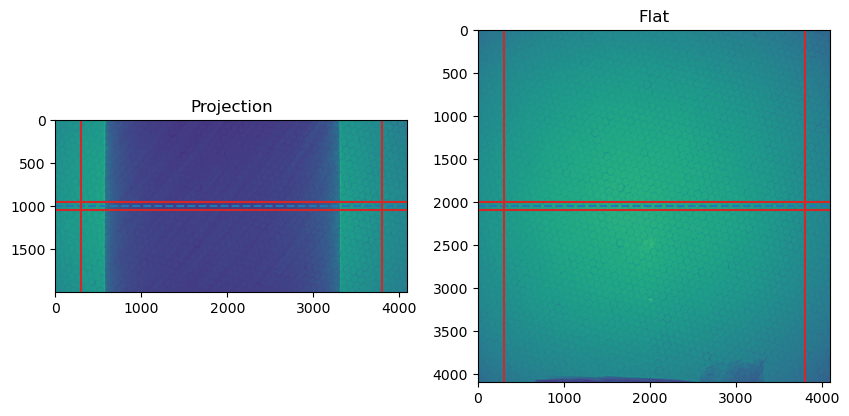

In [4]:
# We assuming here symmetrical cropping
width = 3500 #num_pixels[0]
height = 100 # num_pixels[1] # change here if only limited number of slices in use

# Tomo Files
path_tomo = os.path.join(scan_path,"02-tomo/Output/Binaries")
files_tomo = os.listdir(path_tomo)
files_tomo.sort()

# Flat Files
path_flat = os.path.join(scan_path,"01-ff/Output/Binaries")
files_flat = os.listdir(path_flat)
files_flat.sort()

flat_example = np.array(Image.open(os.path.join(path_flat,files_flat[0])))
proj_example = np.array(Image.open(os.path.join(path_tomo,files_tomo[0])))
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(proj_example)
ax[0].set_title('Projection')
ax[1].imshow(flat_example)
ax[1].set_title('Flat')


# display central slice
ax[0].axhline(proj_example.shape[0]//2,linestyle='--')
ax[1].axhline(flat_example.shape[0]//2,linestyle='--')

# calculate index positions
roi_tomo = [proj_example.shape[1]//2 - width //2,
            proj_example.shape[0]//2 - height //2,
            proj_example.shape[1]//2 + width //2,
            proj_example.shape[0]//2 + height //2]

roi_flat = [flat_example.shape[1]//2 - width //2,
            flat_example.shape[0]//2 - height //2,
            flat_example.shape[1]//2 + width //2,
            flat_example.shape[0]//2 + height //2]
ax[0].axvline(roi_tomo[0],color='tab:red')
ax[0].axvline(roi_tomo[2],color='tab:red')
ax[0].axhline(roi_tomo[1],color='tab:red')
ax[0].axhline(roi_tomo[3],color='tab:red')
ax[1].axvline(roi_flat[0],color='tab:red')
ax[1].axvline(roi_flat[2],color='tab:red')
ax[1].axhline(roi_flat[1],color='tab:red')
ax[1].axhline(roi_flat[3],color='tab:red')

### Load Data

If an ROI was chosen above, only the chosen ROI is imported.

In [5]:
# Load tomography data
print('Importing Projections...')
data = []
for file in tqdm(files_tomo):
    with Image.open(os.path.join(path_tomo,file)) as img:
        # Crop the image to the ROI (left, upper, right, lower)
        roi = img.crop(tuple(roi_tomo))
    data.append(roi)
data = np.array(data)

print('Importing Flat Images...')
flats = []
for file in tqdm(files_flat):
    with Image.open(os.path.join(path_flat,file)) as img:
        # Crop the image to the ROI (left, upper, right, lower)
        roi = img.crop(tuple(roi_flat))
    flats.append(roi)
flats = np.array(flats)

Importing Projections...


  0%|          | 0/2001 [00:00<?, ?it/s]

Importing Flat Images...


  0%|          | 0/10 [00:00<?, ?it/s]

## Define Geometry

The image geometry is defined using the metadata retrieved from the Exciscope scans using the CIL logic.

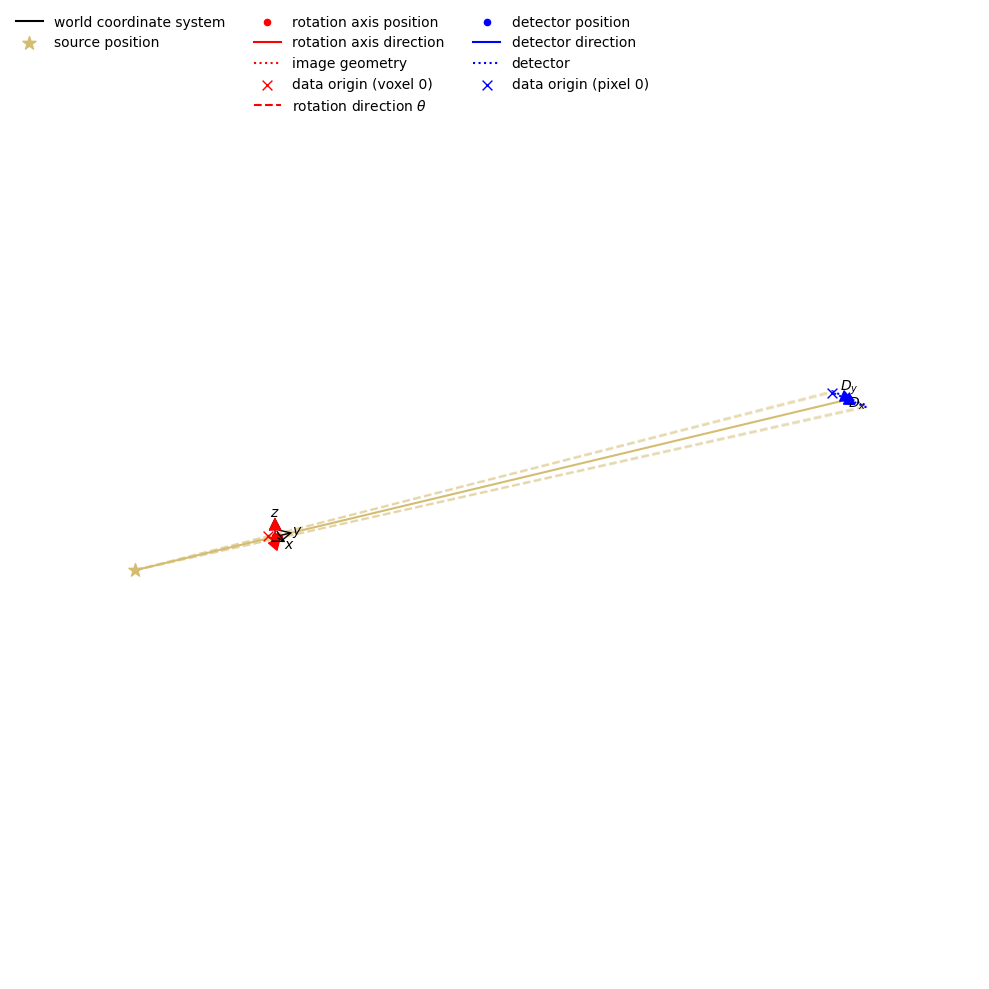

In [6]:
ag = AcquisitionGeometry.create_Cone3D(source_position=[0,-source_object_mm,0],detector_position=[0,source_detector_mm-source_object_mm,0], units = 'mm')\
    .set_panel(num_pixels=[data.shape[2], data.shape[1]], pixel_size=(px_size, px_size))\
    .set_angles(angles=np.arange(0,360+step_size_deg,step_size_deg))
show_geometry(ag)
ig = ag.get_ImageGeometry()
ig.voxel_size_x = voxel_size_mm
ig.voxel_size_y = voxel_size_mm

## Normalize Data

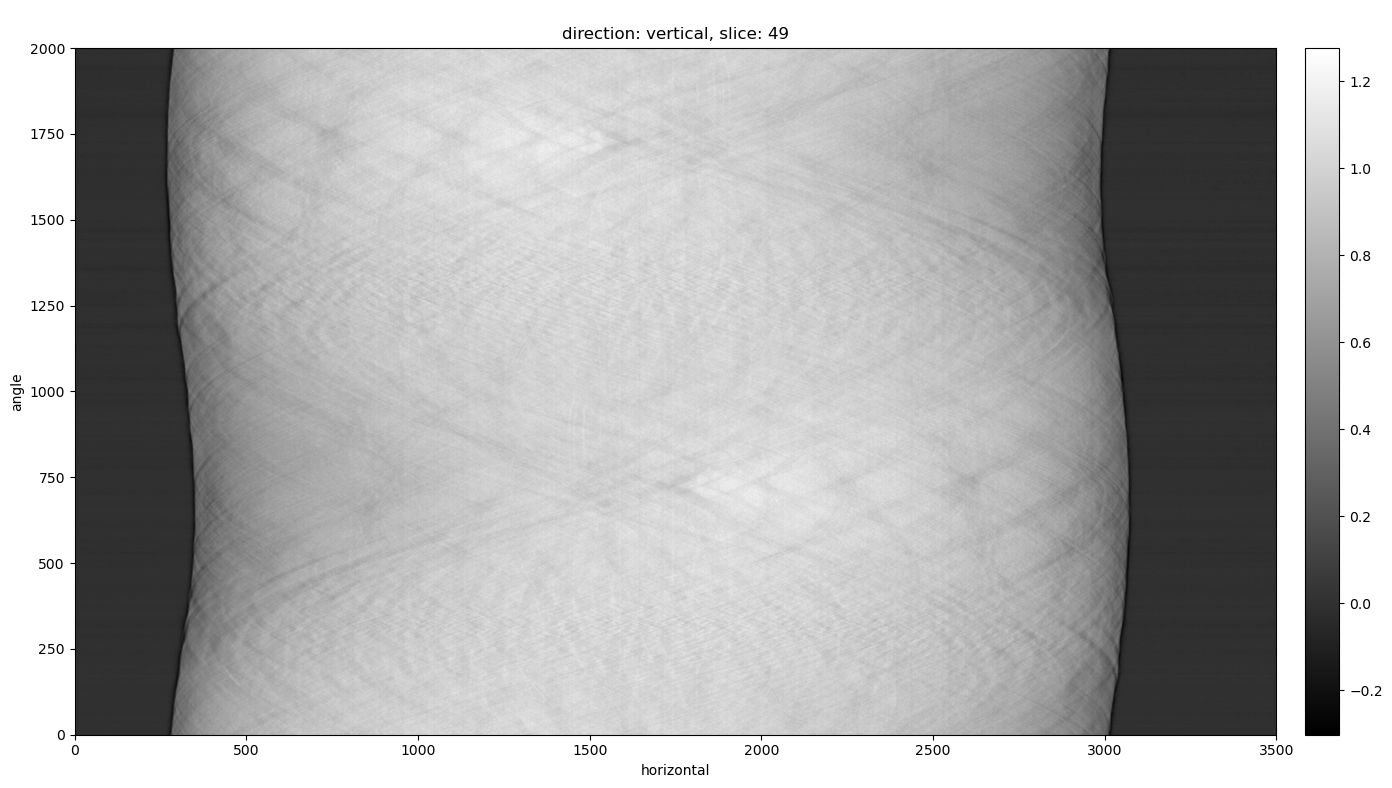

In [7]:
corrected = data / np.average(flats, axis = 0)
del data, flats
corrected = corrected.astype('float32')
sinogram = AcquisitionData(corrected, geometry=ag)
sino = TransmissionAbsorptionConverter()(sinogram)
show2D(sino, slice_list=('vertical', 49))

## Center-of-Rotation

FDK recon

Input Data:
	angle: 2001
	vertical: 100
	horizontal: 3500

Reconstruction Volume:
	vertical: 100
	horizontal_y: 3500
	horizontal_x: 3500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



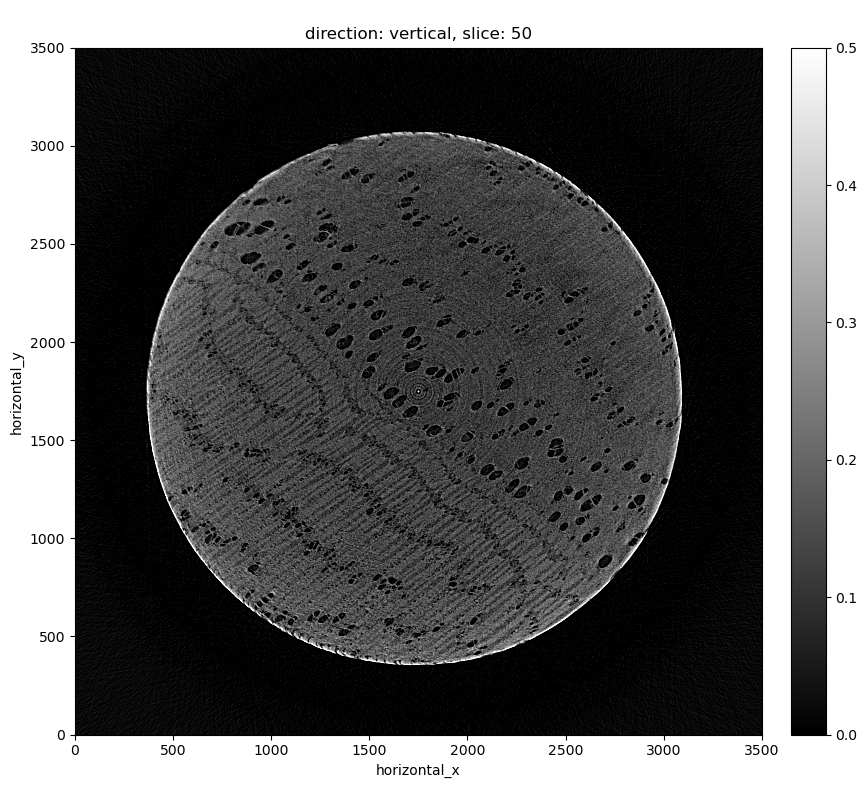

In [8]:
sino.reorder(order='tigre')
processor = CentreOfRotationCorrector.image_sharpness('centre', backend='tigre')
processor.set_input(sino)
sino = processor.get_output()

# Test reconstructionto inspect correct CoR
fdk =  FDK(sino, ig)
recon = fdk.run()
show2D(recon, fix_range = [(0, 0.5)])

## Ring Artefact Removal

Finish Ring Remover
FDK recon

Input Data:
	angle: 2001
	vertical: 100
	horizontal: 3500

Reconstruction Volume:
	vertical: 100
	horizontal_y: 3500
	horizontal_x: 3500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



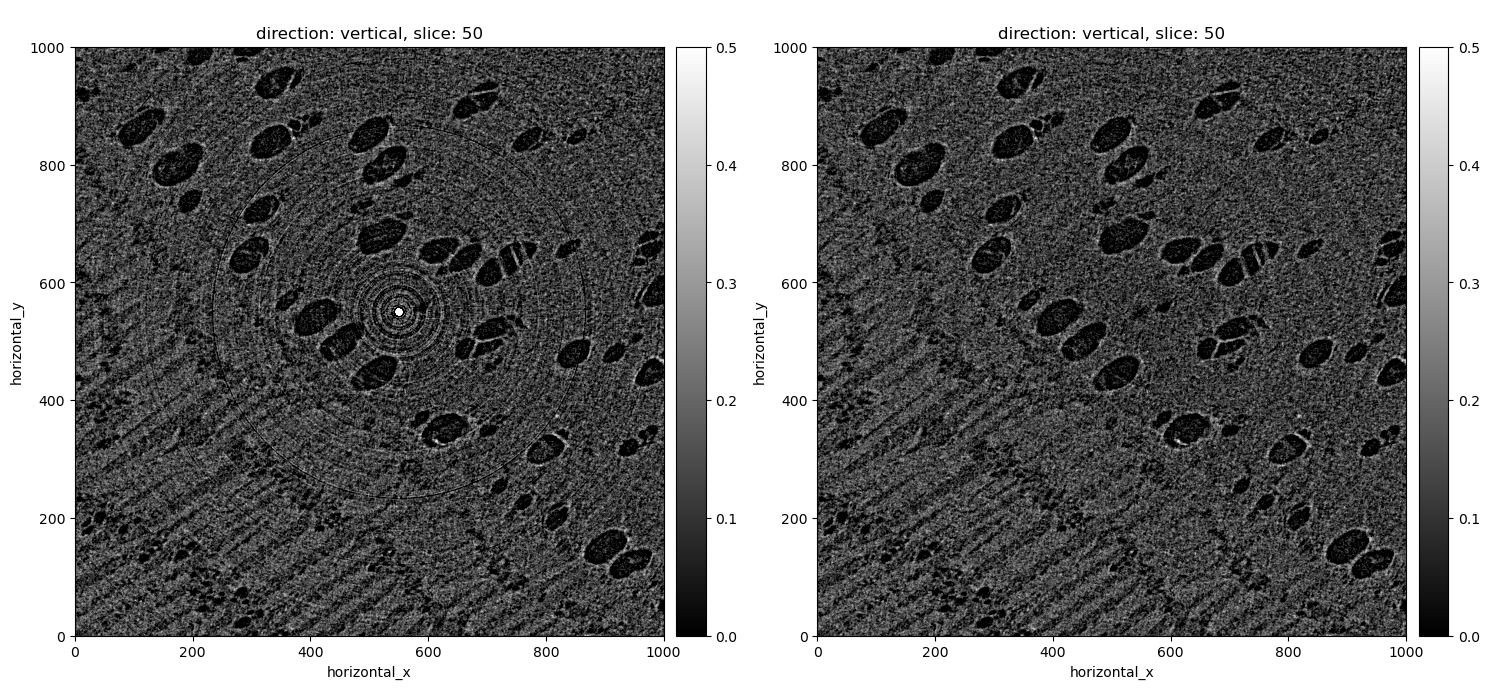

In [9]:
ringRemove = RingRemover()
ringRemove.set_input(sino)
sino_rings = ringRemove.get_output()

fdk_rings = FDK(sino_rings, ig)
recon_rings = fdk_rings.run()

# plot comparison with and with less rings
roi = {'horizontal_y':(1200,2200,1),'horizontal_x':(1200,2200,1)}
slicing = Slicer(roi)
slicing.set_input(recon)
recon_sliced = slicing.get_output()

slicing.set_input(recon_rings)
recon_rings_sliced = slicing.get_output()

show2D([recon_sliced, recon_rings_sliced], fix_range = [(0, 0.5), (0, 0.5)])

## Paganin Phase Retrieval

100%|█████████████████| 2001/2001 [00:36<00:00, 55.53it/s]


FDK recon

Input Data:
	angle: 2001
	vertical: 100
	horizontal: 3500

Reconstruction Volume:
	vertical: 100
	horizontal_y: 3500
	horizontal_x: 3500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



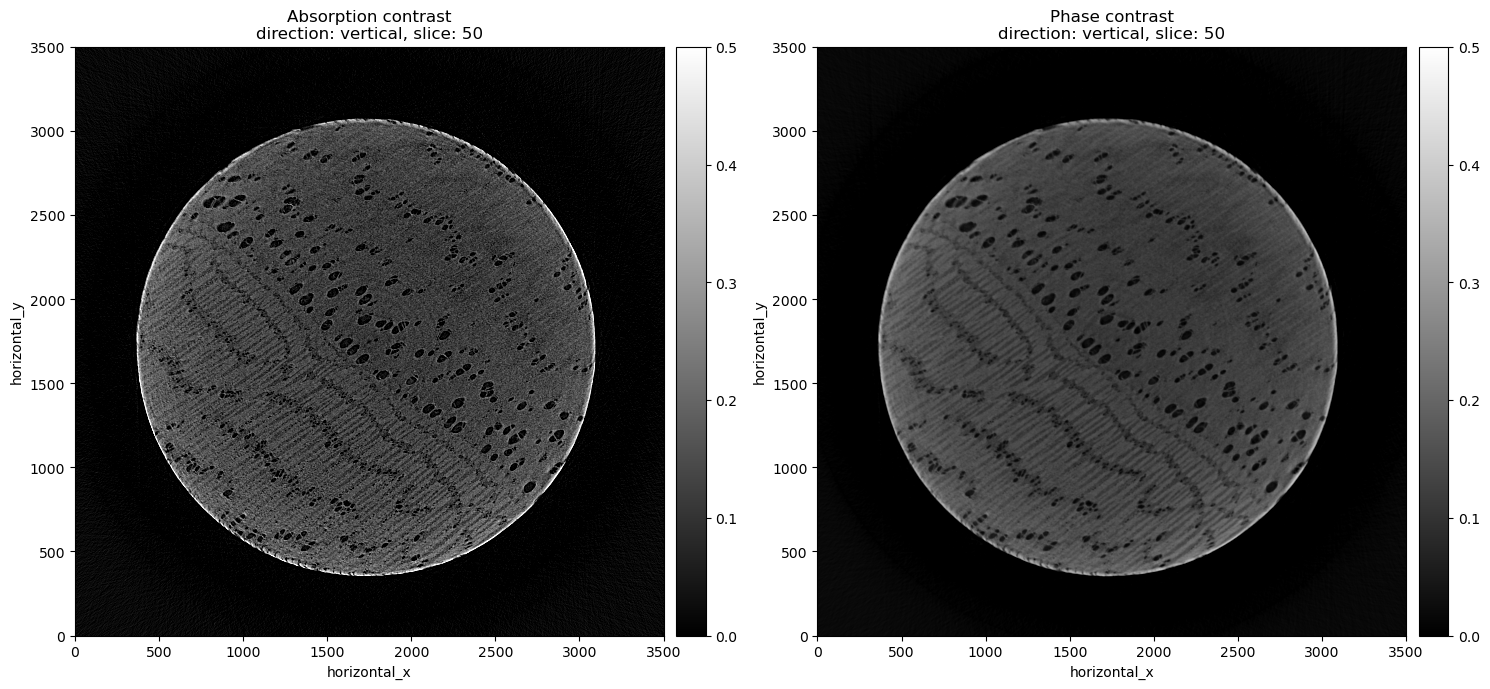

In [10]:
# phase retrieval for one material
energy = 10000
delta = 2.63154061E-06 # the used parameters here are polycarbonat at 10 keV
beta = 3.26059624E-09

paganin_processor = PaganinProcessor(delta = delta, beta = beta, energy = energy, full_retrieval= False)
paganin_processor.set_input(sino_rings)
sino_pag = paganin_processor.get_output()

fdk =  FDK(sino_pag, ig)
recon_pag = fdk.run()
show2D([recon_rings, recon_pag], title = ['Absorption contrast', 'Phase contrast'], fix_range=[(0, 0.5), (0, 0.5)])

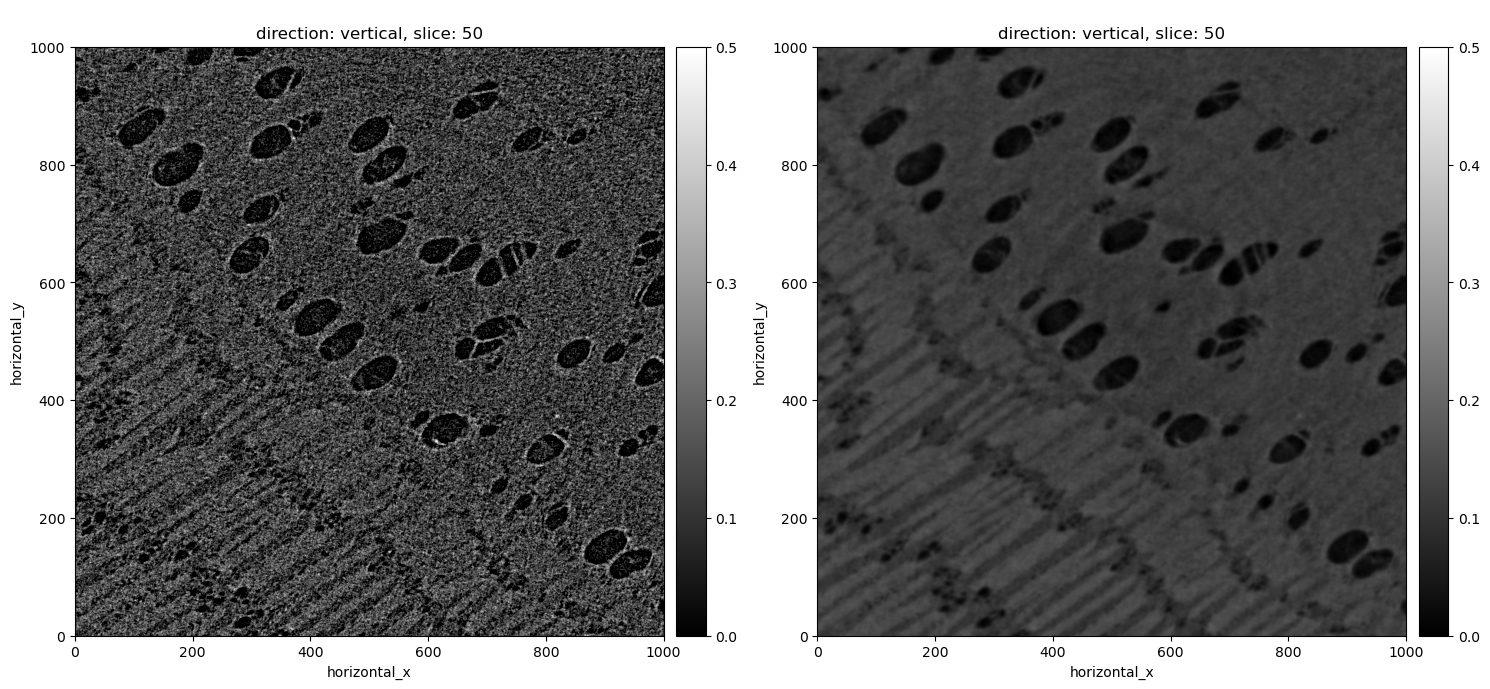

In [11]:
slicing.set_input(recon_pag)
recon_pag_sliced = slicing.get_output()

show2D([recon_rings_sliced, recon_pag_sliced], fix_range = [(0, 0.5), (0, 0.5)])

In [12]:
paganin_processor = PaganinProcessor(delta = 1e-12, beta = beta, energy =  energy, full_retrieval= False)
paganin_processor.set_input(sino_rings)
sino_pag_smaller = paganin_processor.get_output()

fdk =  FDK(sino_pag_smaller, ig)
recon_pag_smaller = fdk.run()

100%|█████████████████| 2001/2001 [00:36<00:00, 54.90it/s]


FDK recon

Input Data:
	angle: 2001
	vertical: 100
	horizontal: 3500

Reconstruction Volume:
	vertical: 100
	horizontal_y: 3500
	horizontal_x: 3500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



In [13]:
paganin_processor = PaganinProcessor(beta = 1e-4, energy =  energy, full_retrieval= False)
paganin_processor.set_input(sino_rings)
sino_pag_default = paganin_processor.get_output()

fdk =  FDK(sino_pag_default, ig)
recon_pag_default = fdk.run()


100%|█████████████████| 2001/2001 [00:36<00:00, 55.18it/s]


FDK recon

Input Data:
	angle: 2001
	vertical: 100
	horizontal: 3500

Reconstruction Volume:
	vertical: 100
	horizontal_y: 3500
	horizontal_x: 3500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



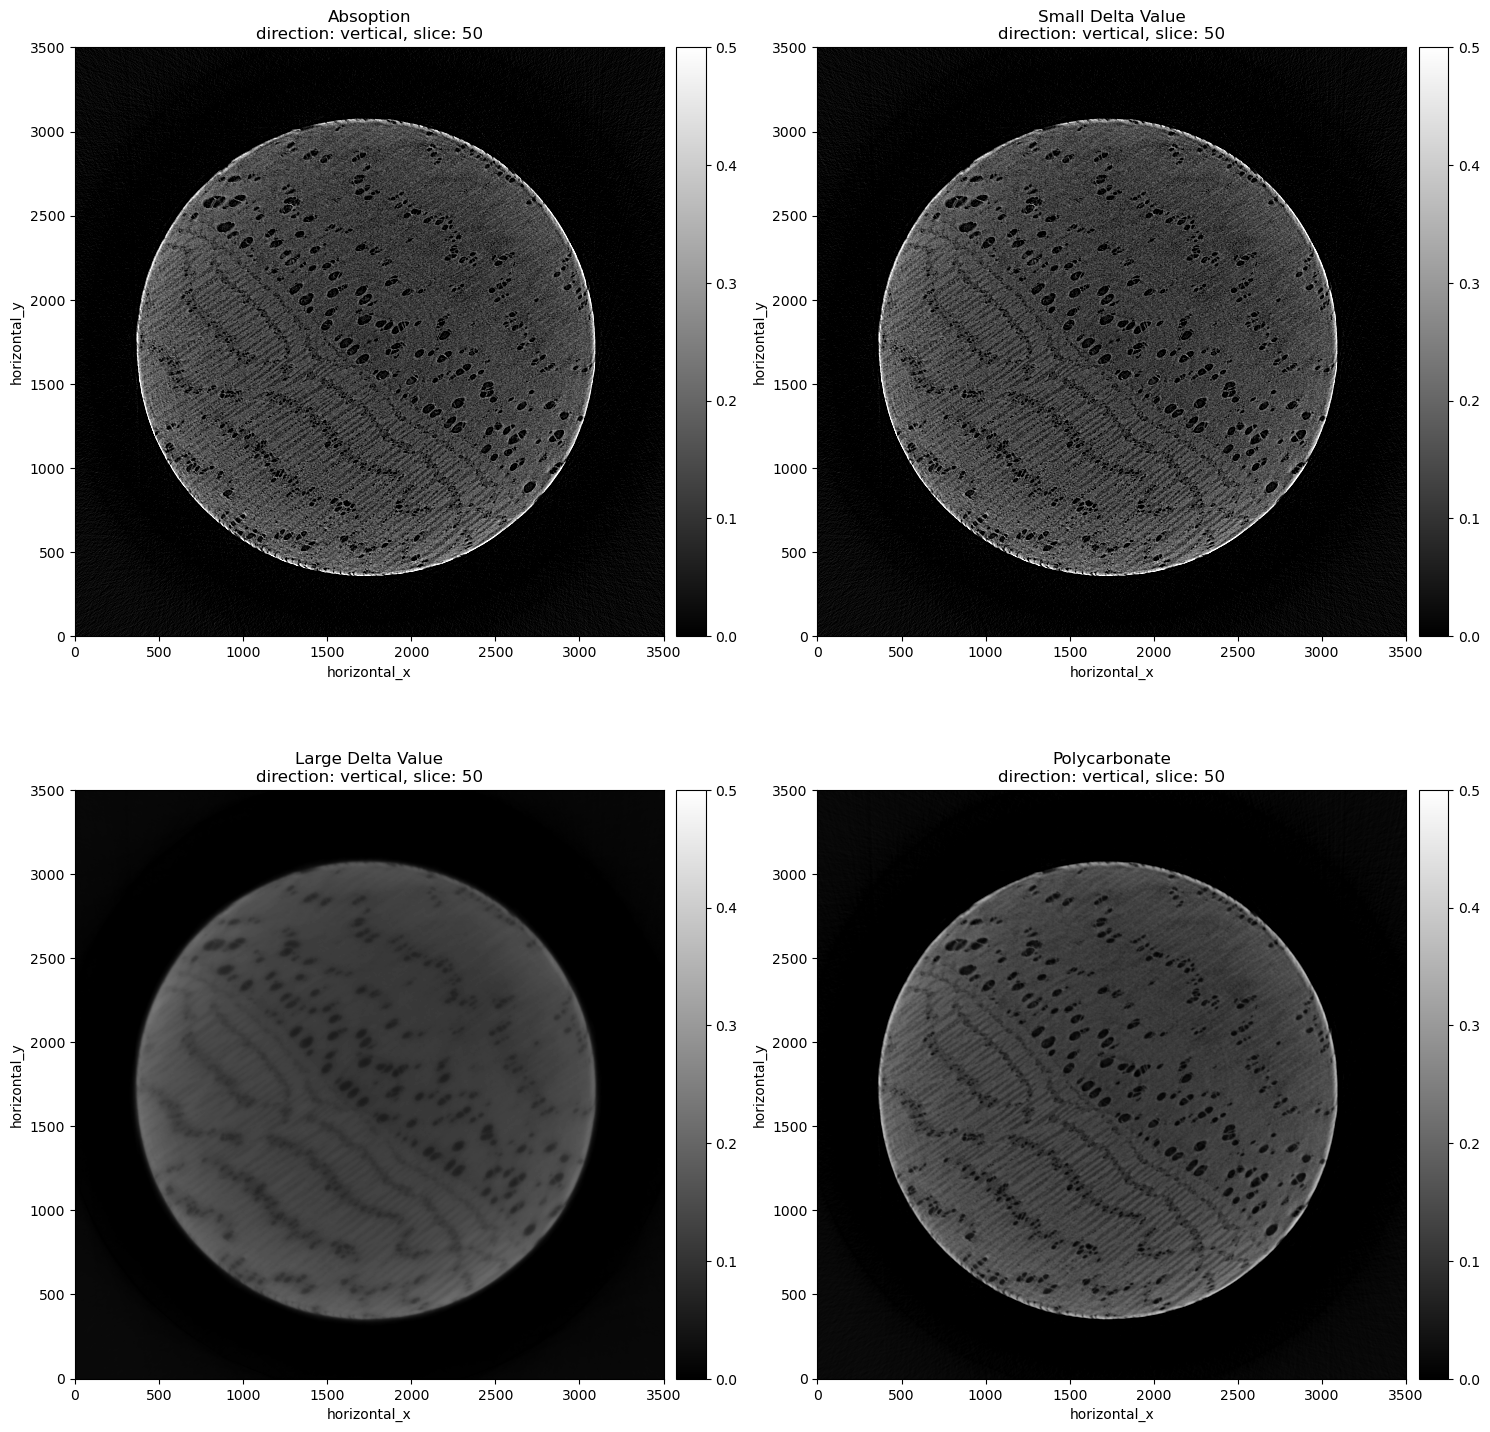

In [14]:
show2D([recon_rings, recon_pag_smaller, recon_pag_default, recon_pag], title = ['Absoption', 'Small Delta Value', 'Large Delta Value', 'Polycarbonate'], fix_range=[(0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)])

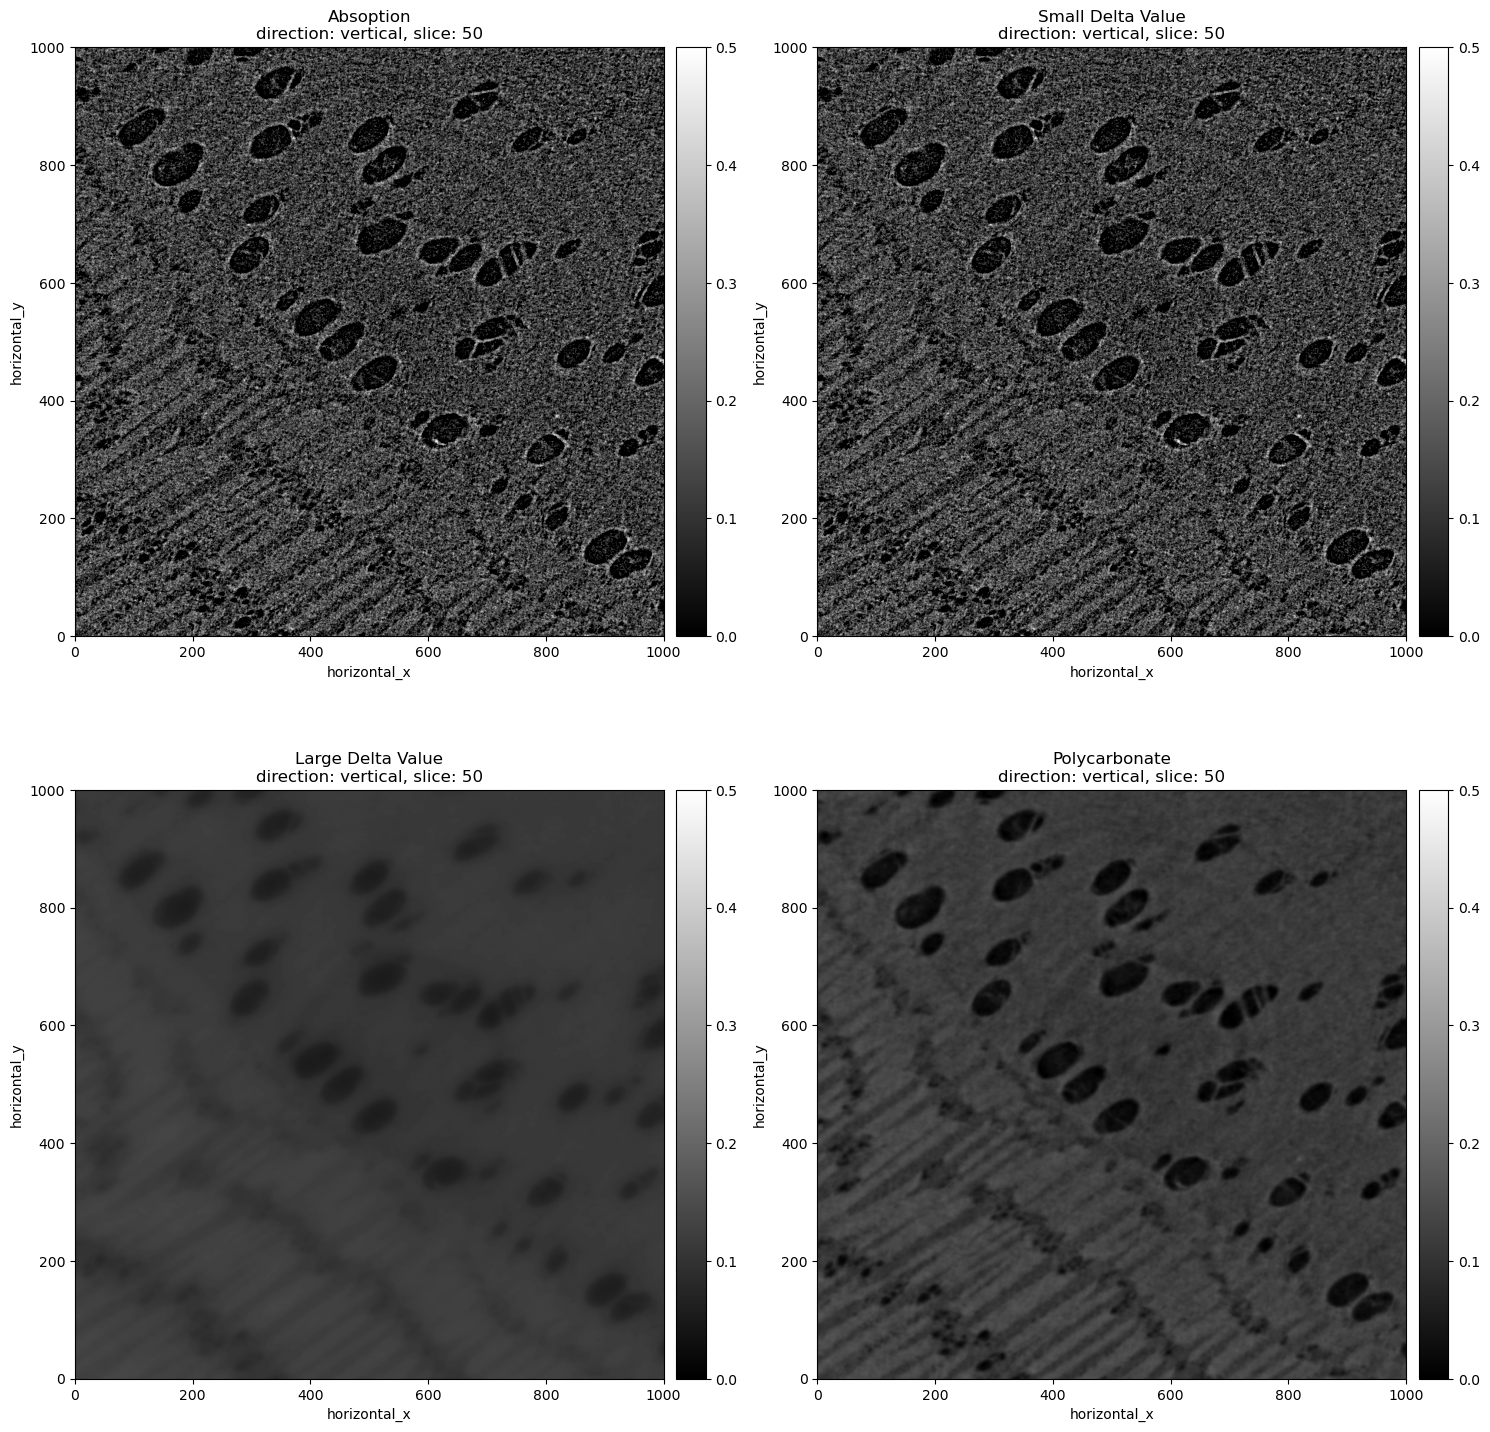

In [15]:
slicing.set_input(recon_pag_default)
recon_pag_default_sliced = slicing.get_output()

slicing.set_input(recon_pag_smaller)
recon_pag_smaller_sliced = slicing.get_output()

show2D([recon_rings_sliced, recon_pag_smaller_sliced, recon_pag_default_sliced, recon_pag_sliced], title = ['Absoption', 'Small Delta Value', 'Large Delta Value', 'Polycarbonate'], fix_range = [(0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)])

## Data Export

The data is exported using the qim3d package. 4 version are exported:
* Phase contrast full volume (of the ROI selected at the beginning)
* Phase contrast downsampled volume
* Absoption contrast full volume
* Absoption contrast downsampled volume

All volumes are exported as TIFF stacks. 

### Data Cropping

In [16]:
recon_pag_roi = recon_pag.as_array()[:,500:-500,500:-500]
recon_roi = recon.as_array()[:,500:-500,500:-500]

### Saving of Absorption Data

In [ ]:
recon_pag_roi = recon_pag_roi.astype('float16')
qim3d.io.save(output_dir+f"/{recon_name}_recon_pag.tiff",recon_pag_roi,replace=True)
qim3d.io.save(output_dir+f"/{recon_name}_recon_pag_4x4.tiff",recon_pag_roi[:,::4,::4],replace=True)

### Saving of Phase Retrieved Data

In [ ]:
recon_roi = recon_roi.astype('float16')
qim3d.io.save(output_dir+f"/{recon_name}_recon_abs.tiff",recon_roi,replace=True)
qim3d.io.save(output_dir+f"/{recon_name}_recon_abs.tiff",recon_roi[:,::4,::4],replace=True)

## Inspect 3D Volume

The volume can be visualised using the qim3d package.

In [ ]:
qim3d.viz.vol(recon_pag_roi[:,::4,::4])